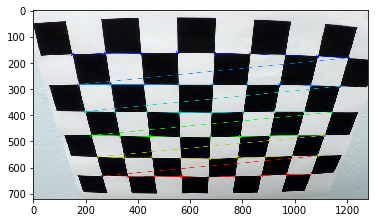

In [4]:
#Calibrating the camera
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# prepare object points
nx = 9 #TODO: enter the number of inside corners in x
ny = 6 #TODO: enter the number of inside corners in y

# Make a list of calibration images
fname = './camera_cal/calibration2.jpg'
img = cv2.imread(fname)

# Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Find the chessboard corners
ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

# If found, draw corners
if ret == True:
    # Draw and display the corners
    cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
    plt.imshow(img)


In [ ]:
#distortion correction
def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    #undist = np.copy(img)  # Delete this line
    return undist
objpoints = 
imgpoints=


undistorted = cal_undistort(img, objpoints, imgpoints)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)